In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [8]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
# data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
data.shape

(161764, 33538)

In [8]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [9]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [10]:
# Level 1 ADlasso features by loss difference convergence
import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/feature_selection')
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\feature_selection")

types = ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [11]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,13,7
CD4_T,200,83
CD8_T,25,6
DC,25,15
Mono,21,11
NK,28,14
other,42,27
other_T,61,26


## Get likelihood from LR model

In [18]:
def LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))

    # calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype
    print(type(likelihood), likelihood.shape)
    #do the row-wise softmax
    # likelihood = np.exp(likelihood)/np.sum(np.exp(likelihood),1,keepdims=True)
    
    return likelihood


In [19]:
celltype = 'B'
B_likelihood = LR_likelihood(data, features_dict, celltype)
B_likelihood.shape

Celltype: B
decision_scores > 0: 13797
likelihood > 0.5: 13797
<class 'numpy.ndarray'> (161764,)


(161764,)

In [20]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood(data, features_dict, celltype)

Celltype: B
decision_scores > 0: 13797
likelihood > 0.5: 13797
<class 'numpy.ndarray'> (161764,)
Celltype: CD4_T
decision_scores > 0: 41021
likelihood > 0.5: 41021
<class 'numpy.ndarray'> (161764,)
Celltype: CD8_T
decision_scores > 0: 24604
likelihood > 0.5: 24604
<class 'numpy.ndarray'> (161764,)
Celltype: DC
decision_scores > 0: 3557
likelihood > 0.5: 3557
<class 'numpy.ndarray'> (161764,)
Celltype: Mono
decision_scores > 0: 49941
likelihood > 0.5: 49941
<class 'numpy.ndarray'> (161764,)
Celltype: NK
decision_scores > 0: 18711
likelihood > 0.5: 18711
<class 'numpy.ndarray'> (161764,)
Celltype: other
decision_scores > 0: 2743
likelihood > 0.5: 2743
<class 'numpy.ndarray'> (161764,)
Celltype: other_T
decision_scores > 0: 5700
likelihood > 0.5: 5700
<class 'numpy.ndarray'> (161764,)


In [21]:
data.obs['celltype.l1'].value_counts()

celltype.l1
Mono       49010
CD4_T      41001
CD8_T      25469
NK         18664
B          13800
other_T     6789
DC          3589
other       3442
Name: count, dtype: int64

In [56]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,1.404770e-06,0.000095,0.000347,9.861753e-06,9.436343e-01,2.385146e-06,0.002143,0.000071
1,5.349328e-07,0.997527,0.013055,1.222594e-14,2.342952e-10,2.234398e-06,0.004022,0.001214
2,4.825896e-06,0.010334,0.998874,5.509071e-14,5.731363e-12,2.098368e-05,0.003307,0.008626
3,6.481929e-07,0.000123,0.010338,1.085362e-13,4.362391e-10,9.998705e-01,0.001026,0.008453
4,3.412856e-08,0.000912,0.994669,1.715550e-18,1.307734e-07,2.185635e-07,0.006052,0.005609


In [3]:
likelihood_df = pd.read_csv('L1_likelihood_df.csv')
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,1.404770e-06,0.000095,0.000347,9.861753e-06,9.436343e-01,2.385146e-06,0.002143,0.000071
1,5.349328e-07,0.997527,0.013055,1.222594e-14,2.342952e-10,2.234398e-06,0.004022,0.001214
2,4.825896e-06,0.010334,0.998874,5.509071e-14,5.731363e-12,2.098368e-05,0.003307,0.008626
3,6.481929e-07,0.000123,0.010338,1.085362e-13,4.362391e-10,9.998705e-01,0.001026,0.008453
4,3.412856e-08,0.000912,0.994669,1.715550e-18,1.307734e-07,2.185635e-07,0.006052,0.005609


In [4]:
# row sum
likelihood_df.sum(axis=1)


0         0.946304
1         1.015821
2         1.021167
3         1.019812
4         1.007242
            ...   
161759    1.054958
161760    1.003057
161761    1.003284
161762    0.995774
161763    0.962423
Length: 161764, dtype: float64

### 20231227: add softmax operation to likelihood, poor result

In [58]:
# Applying row-wise softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

likelihood_softmax = pd.DataFrame(softmax(likelihood_df.values), columns=likelihood_df.columns)
likelihood_softmax.shape

(161764, 8)

In [33]:
# row-wise softmax
# likelihood_softmax = likelihood_df.values
# likelihood_softmax = np.exp(likelihood_softmax)/np.sum(np.exp(likelihood_softmax),1,keepdims=True)
# likelihood_softmax = pd.DataFrame(likelihood_softmax, columns=likelihood_df.columns)
# likelihood_softmax.shape

(161764, 8)

In [59]:
likelihood_softmax

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0.104472,0.104482,0.104508,0.104473,0.268419,0.104472,0.104696,0.104479
1,0.102775,0.278682,0.104126,0.102775,0.102775,0.102776,0.103190,0.102900
2,0.102695,0.103761,0.278839,0.102695,0.102695,0.102697,0.103035,0.103584
3,0.102691,0.102704,0.103758,0.102691,0.102691,0.279107,0.102796,0.103563
4,0.102918,0.103012,0.278274,0.102918,0.102918,0.102918,0.103543,0.103497
...,...,...,...,...,...,...,...,...
161759,0.102555,0.104413,0.274912,0.102554,0.102557,0.102554,0.102644,0.107811
161760,0.102927,0.102918,0.102950,0.102918,0.278969,0.102956,0.103443,0.102919
161761,0.279613,0.102885,0.102959,0.102864,0.102911,0.102864,0.103041,0.102864
161762,0.103463,0.103404,0.103408,0.104440,0.274063,0.103395,0.104432,0.103394


In [60]:
likelihood_softmax.sum(axis=1)



0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
161759    1.0
161760    1.0
161761    1.0
161762    1.0
161763    1.0
Length: 161764, dtype: float64

In [36]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\LR_likelihood")

likelihood_softmax.to_csv('L1_likelihood_softmax_df.csv', index=False)

## (1st_type / 2nd_type) >= 1.5

In [37]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(161764, 6)

In [38]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.268419,Mono,0.104696,other,2.563802,Mono
1,0.278682,CD4_T,0.104126,CD8_T,2.676397,CD4_T
2,0.278839,CD8_T,0.103761,CD4_T,2.687309,CD8_T
3,0.279107,NK,0.103758,CD8_T,2.689978,NK
4,0.278274,CD8_T,0.103543,other,2.687516,CD8_T
5,0.197526,CD8_T,0.115211,other_T,1.714464,CD8_T
6,0.276959,Mono,0.103424,other,2.677887,Mono
7,0.279251,B,0.103436,other,2.699742,B
8,0.279075,NK,0.104223,other_T,2.677664,NK
9,0.277877,CD8_T,0.107912,CD4_T,2.575044,CD8_T


In [39]:
sum(result_df['Assignment'] == 'Uncertain')

12915

In [40]:
12915/len(result_df)

0.07983853020449544

## Assign the celltype with the largest likelihood (no odds ratio)

In [5]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [6]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.943634,Mono,Mono
1,0.997527,CD4_T,CD4_T
2,0.998874,CD8_T,CD8_T
3,0.999871,NK,NK
4,0.994669,CD8_T,CD8_T
5,0.546333,CD8_T,CD8_T
6,0.986612,Mono,Mono
7,0.998959,B,B
8,0.999251,NK,NK
9,0.998975,CD8_T,CD8_T


In [13]:
# count 'uncertain'
sum(result_df['Assignment'] == 'Uncertain')

0

## Confusion heatmap

In [18]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [19]:
cm.shape

(8, 9)

In [20]:
cm

Predicted,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T,Uncertain
True,,,,,,,,,
B,13774,2,5,0,4,7,7,1,0
CD4_T,4,40397,362,0,4,10,9,215,0
CD8_T,2,1255,23718,1,2,122,2,367,0
DC,1,4,1,3336,242,1,4,0,0
Mono,5,26,17,63,48838,17,42,2,0
NK,0,16,72,0,4,18518,4,50,0
other,15,164,37,5,623,37,2531,30,0
other_T,1,433,800,0,1,317,4,5233,0


In [3]:
# cm = pd.read_csv('L1_LR_confusion_matrix.csv', index_col=0)
# cm

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T,Uncertain
True,,,,,,,,,
B,13704,2,2,0,3,2,5,0,82
CD4_T,1,39892,236,0,2,8,5,139,718
CD8_T,1,836,22238,0,2,68,0,262,2062
DC,0,2,1,3090,140,0,4,0,352
Mono,1,22,9,24,48679,5,31,1,238
NK,0,15,46,0,3,18312,2,32,254
other,9,140,28,1,535,23,2483,20,203
other_T,0,317,436,0,0,174,2,4653,1207


In [51]:
# export confusion matrix
# cm.to_csv('L1_LR_confusion_matrix.csv')

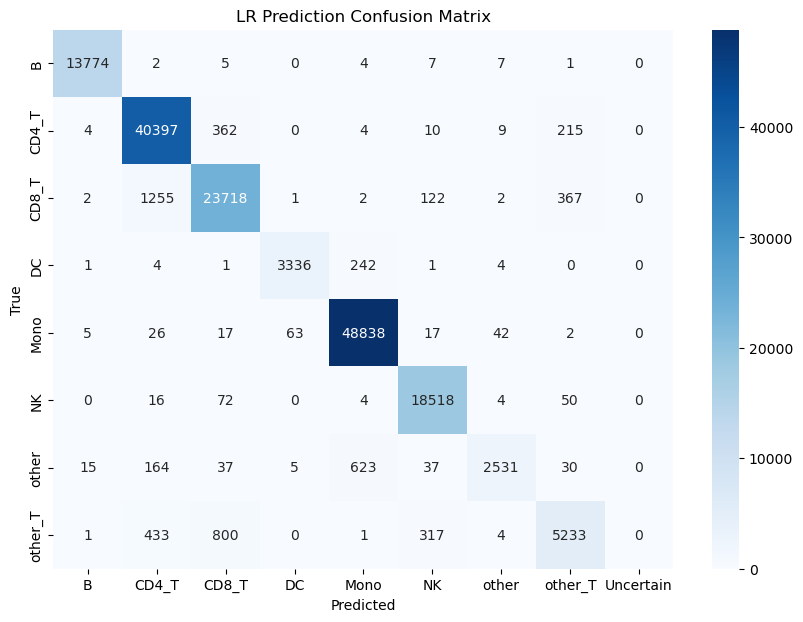

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [22]:
row_sum = cm.sum(axis=1)
row_sum


True
B          13800
CD4_T      41001
CD8_T      25469
DC          3589
Mono       49010
NK         18664
other       3442
other_T     6789
dtype: int64

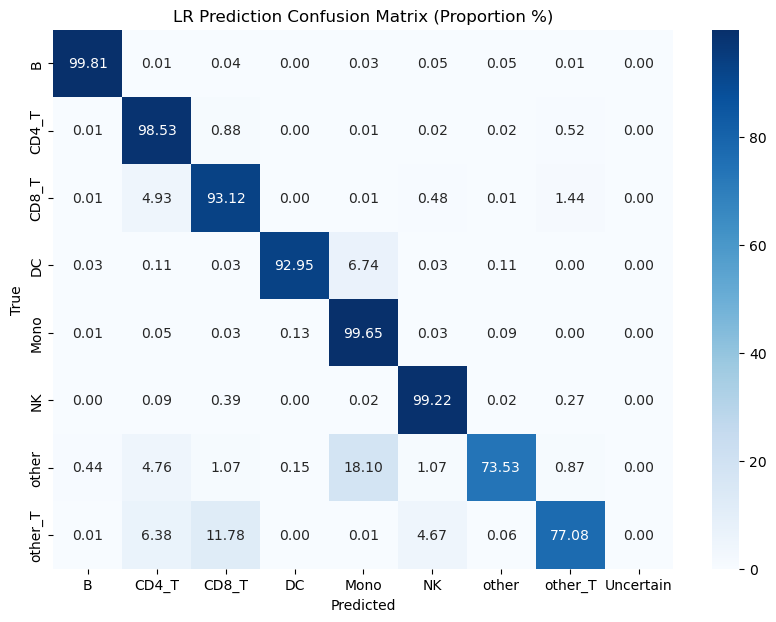

In [23]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 7))
sns.heatmap(cm_proportion, fmt=".2f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

## Calculate accuracy

In [24]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9665005810934447

In [25]:
cm.values.sum()

161764